# S&P 500 Stock Selection
## SQL Database and Data Analysis Using Python
<hr style="border:1px solid gray">

## Table Of Contents
1. [Project Objective](#projectobjective)


2. [Preliminaries](#preliminaries)


3. [Creating SQL Database](#sqldatabase)\
    i. [Updating SQL Database](#sqldatabase2)\
    ii. [Importing From SQL Database](#sqldatabase3)
    
    
4. [Analysis](#analysis)\
    i. [Initial Stocks Selection](#analysis2)\
    ii. [Performance Calculations](#analysis3)\
    iii. [Results Comparison](#analysis4)


5. [Final Results](#final)

<hr style="border:1px solid gray">

## Project Objective <a name="projectobjective"></a>

The primary goal of this project is to find five stocks from the S&P 500 index that can be held over a 3-year period in an equal-weighted portfolio that can outperform the index on an absolute and risk-adjusted basis.

### Process to find the five stocks:

* Retrieve data for S&P 500 stocks, also including stocks removed from the index to avoid survivorship bias.

    
* Create two hypothetical portfolios; one with five stocks chosen based on Sharpe ratio, and the other chosen based on mean daily returns. Data used for calculations will be from a 5-year period starting from 2015-01-01 to 2020-01-01. 

    
* Calculate metrics for both these portfolios using data of the next 3 years, starting from 2020-01-01 to 2023-01-01, and compare this with the performance of the S&P 500 index. 

   
* Select the portfolio that had the best performance and use the same selection criteria to choose another five stocks, this time using data for a more recent 5-year period, starting from 2018-01-01 to 2023-01-01. This portfolio will be the final result of the analysis. 
    

## Data
### SQL Database Creation

Stock data will be downloaded from Yahoo Finance using the yfinance Python library. It will then be transferred to an SQL database using the SQL toolkit SQLalchemy and SQlite. There is a function within this project to update the SQL database without re-downloading the initial data. The data will then be retrieved from this database in order to do analysis in Python. 

### Addressing Survivorship Bias

As the S&P 500 components get updated periodically, the dataset must be modified to include companies that were removed from the index to avoid survivorship bias. Stock prices will only be shown on dates when the company was included in the index. 

<hr style="border:1px solid gray">

### Preliminaries <a name="preliminaries"></a>

In [1]:
# Import packages required.
import pandas as pd
import numpy as np
import yfinance as yf
from sqlalchemy import create_engine
import datetime 
import matplotlib.pyplot as plt

In [2]:
# Getting dataframe with ticker names and date added to S&P500 from Wikipedia page.
SPYtickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0][['Symbol', 'Date added']]
SPYtickers

,Symbol,Date added
0,MMM,1957-03-04
1,AOS,2017-07-26
2,ABT,1957-03-04
3,ABBV,2012-12-31
4,ACN,2011-07-06
...,...,...
498,YUM,1997-10-06
499,ZBRA,2019-12-23
500,ZBH,2001-08-07
501,ZION,2001-06-22


In [3]:
# Creating a list with all current SPY ticker names. Removed tickers will be added to this list later as well.
SPYalltickers = SPYtickers['Symbol'].to_list()

In [4]:
# Analysis starting date will be 2015-01-01, so filtering out another dataframe that only lists names added after 2015-01-01.
SPY2015 = SPYtickers[SPYtickers['Date added'] > '2015-01-01']
SPY2015

,Symbol,Date added
1,AOS,2017-07-26
5,ATVI,2015-08-31
9,AAP,2015-07-09
15,ALK,2016-05-13
16,ALB,2016-07-01
...,...,...
478,WAB,2019-02-27
481,WBD,2022-04-11
487,WST,2020-05-22
493,WTW,2016-01-05


In [5]:
# Find the tickers that had been removed from the index.
# On the same wikipedia page, there is another table that lists date and component changes of the S&P 500.
removed_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1][['Date', 'Removed']]
removed_tickers

Date Removed                          
                  Date  Ticker                  Security
0        June 20, 2023    DISH              Dish Network
1          May 4, 2023     FRC       First Republic Bank
2       March 20, 2023    LUMN        Lumen Technologies
3       March 15, 2023    SBNY            Signature Bank
4       March 15, 2023    SIVB       SVB Financial Group
..                 ...     ...                       ...
320       June 9, 1999     HPH  Harnischfeger Industries
321  December 11, 1998     LDW                     Amoco
322  December 11, 1998     GRN                General Re
323  December 11, 1998     SUN                SunAmerica
324      June 17, 1997     USL                    USLife

[325 rows x 3 columns]

In [6]:
# Set date as index
removed_tickers = removed_tickers.set_index(removed_tickers['Date']['Date'])
removed_tickers.head()

Date Removed                     
                          Date  Ticker             Security
Date                                                       
June 20, 2023    June 20, 2023    DISH         Dish Network
May 4, 2023        May 4, 2023     FRC  First Republic Bank
March 20, 2023  March 20, 2023    LUMN   Lumen Technologies
March 15, 2023  March 15, 2023    SBNY       Signature Bank
March 15, 2023  March 15, 2023    SIVB  SVB Financial Group

In [7]:
# Setting index as datetime and filtering for start date later than 2015-01-01. 
# Dropping null values as there were rows in the Wikipedia table that were blank in the 'Removed' column.
removed_tickers.index = pd.to_datetime(removed_tickers.index)
removed_tickers = removed_tickers[removed_tickers.index > '2015-01-01']
removed_tickers = removed_tickers['Removed'].dropna()
removed_tickers

,Ticker,Security
Date,,
2023-06-20,DISH,Dish Network
2023-05-04,FRC,First Republic Bank
2023-03-20,LUMN,Lumen Technologies
2023-03-15,SBNY,Signature Bank
2023-03-15,SIVB,SVB Financial Group
...,...,...
2015-03-23,AVP,Avon Products
2015-03-18,CFN,Carefusion
2015-03-12,PETM,PetSmart


In [8]:
# Adding this list of removed tickers to our SPY tickers list.
SPYalltickers.extend(removed_tickers['Ticker'])

In [9]:
# Renaming tickers 'BF.B' and 'BRK.B' to 'BF-B' and 'BRK-B' to make them match with how they are named on Yahoo Finance.
# If tickers do not match, it will not successfully pull the data.
SPYalltickers = ['BF-B' if i=='BF.B' else i for i in SPYalltickers]
SPYalltickers = ['BRK-B' if i=='BRK.B' else i for i in SPYalltickers]

In [10]:
# Checking for duplicates; important when exporting to SQL as it can cause errors if not accounted for.
print(len(SPYalltickers)) 
print(len(set(SPYalltickers)))
# There are duplicates in the list as the lengths do not match. 
# Remove duplicates.
SPYalltickers = list(set(SPYalltickers))

689
683


In [11]:
# Creating function to import data from yfinance to prepare for export to SQL database.
def getdata(tickers):
    data = []
    for ticker in tickers:
        # reset_index to move 'Date' out of index and into column.
        data.append(yf.download(ticker, start='2015-01-01', progress=False).reset_index())
    print('Download complete.')
    return data

In [12]:
%%time
# Running function to a variable and displaying processing time to get total download time.
# Each ticker will have its own dataframe with columns; 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume'.
# NOTE: No need to run again after first import.
SPY = getdata(SPYalltickers)


1 Failed download:
['ESV']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['RHT']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['LO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-14)')

1 Failed download:
['SIVB']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['CERN']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PBCT']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MON']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['STJ']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-14)')

1 Failed download:
['CMCSK']: Exception('%ticker%: No price data found, symbol may be 


1 Failed download:
['WFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-14)')

1 Failed download:
['DPS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-14)')


Download complete.
Wall time: 4min 26s


### Regarding Failed Downloads

There will be multiple failed downloads in the cell above. The reason for this is that the list of removed companies were retrieved from the Wikipedia page, but these companies are no longer listed on Yahoo Finance.

For example;

YHOO - used to be Yahoo!. Acquired by Verizon Communications Inc.

BBBY - Bed Bath & Beyond. Went bankrupt, delisted from major exchanges, and now defunct.

TWTR - Acquired by Elon Musk and taken off public markets.

Companies such as Twitter, Bed Bath & Beyond, and others may have been considered for the stock selection process, but since they are no longer on Yahoo Finance, they are excluded from this dataset. Even though this is important to note, the dataset is still sufficient to achieve the goal of this project.

### Creating SQL Database <a name="sqldatabase"></a>

In [13]:
# Connecting to SQL database named 'SPY500'.
engine = create_engine('sqlite:///SPY500')

In [14]:
# Creating a function to export each stock dataframe to SQL database.
# The ticker names will be the table names in the SQL database, and the dataframes will be the data.
# Added exception handling in order to inform if database has already been created.
def export_sql(dataframes, tickers, engine):
    """
    Exports stock dataframes to SQL database.
    Will not run if database name already exists.
    Ensure no duplicates in ticker list.
    """
    try:
        for dataframe, ticker in zip(dataframes, tickers):
            dataframe.to_sql(ticker, engine, index=False)
        print('Export to SQL database complete')
    except:
        print('Error: Database already exists')     

In [15]:
%%time
# Running function to create the SQL database along with displaying processing time.
export_sql(SPY, SPYalltickers, engine)

Error: Database already exists
Wall time: 387 ms


### Updating SQL Database <a name="sqldatabase2"></a>

In [16]:
# Creating function to update SQL database .
def sql_updater(ticker, start='2023-07-01'):
    """
    Updates SQL database without needing to re-download all initial data
    """
    # Get the latest date from database table.
    max_date = pd.read_sql(f'SELECT MAX(Date) FROM {ticker}', engine).values[0][0]
    print('Latest date: ' + max_date)
    # Added .strip() in order to remove quotations before downloading as these were added for SQL coding.
    new_data = yf.download(ticker.strip('\"'), start=pd.to_datetime(max_date))
    new_rows = new_data[new_data.index > max_date]
    new_rows.to_sql(ticker, engine, if_exists='append')
    print(str(len(new_rows)) + ' new rows imported to DB')

In [17]:
%%time
# Set an if statement to only update during weekends.
# This is to avoid updating SQL database while market is open as values will constantly change until market close.
# Must first run following cell that defines 'tickers' variable. 
if datetime.datetime.today().weekday() < 5:
    print('Wait until weekend to update SQL database.')
else:
    for ticker in tickers: 
        sql_updater(ticker)

Wait until weekend to update SQL database.
Wall time: 0 ns


In [18]:
# Getting an overview of how the SQL database looks like, with ticker names as the table names. 
# Note: I also use the tool 'DB Browser for SQLite' that allows me to view the database and execute SQL code directly on it.
# Ensuring that the number of rows is correct, which should be 683. The tickers that failed to download are empty tables.
pd.read_sql('SELECT * FROM sqlite_master', engine)

,type,name,tbl_name,rootpage,sql
0,table,RF,RF,2,"CREATE TABLE ""RF"" (\n\t""Date"" DATETIME, \n\t""O..."
1,table,MCHP,MCHP,48,"CREATE TABLE ""MCHP"" (\n\t""Date"" DATETIME, \n\t..."
2,table,PH,PH,93,"CREATE TABLE ""PH"" (\n\t""Date"" DATETIME, \n\t""O..."
3,table,BKR,BKR,138,"CREATE TABLE ""BKR"" (\n\t""Date"" DATETIME, \n\t""..."
4,table,NUE,NUE,183,"CREATE TABLE ""NUE"" (\n\t""Date"" DATETIME, \n\t""..."
...,...,...,...,...,...
678,table,FRC,FRC,25798,"CREATE TABLE ""FRC"" (\n\t""Date"" TEXT, \n\t""Open..."
679,table,CPGX,CPGX,25799,"CREATE TABLE ""CPGX"" (\n\t""Date"" TEXT, \n\t""Ope..."
680,table,IVZ,IVZ,25800,"CREATE TABLE ""IVZ"" (\n\t""Date"" DATETIME, \n\t""..."
681,table,RIG,RIG,25845,"CREATE TABLE ""RIG"" (\n\t""Date"" DATETIME, \n\t""..."


### Creating Dataframe From SQL Database <a name="sqldatabase3"></a>

In [19]:
# Creating a variable to store a list of all the ticker names from SQL database.
tickers = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', engine)['name'].to_list()

In [20]:
# Need to modify some tickers as it will cause issues when they are inserted into SQL code in the following cell.
tickers = ['"ALL"' if i=='ALL' else i for i in tickers] # need to modify otherwise SQL reads it as 'FROM ALL'
tickers = ['"ON"' if i=='ON' else i for i in tickers] # need to modify otherwise SQL reads it as 'FROM ON'
tickers = ['"BF-B"' if i=='BF-B' else i for i in tickers] # need to modify due to SQL reading "-"
tickers = ['"BRK-B"' if i=='BRK-B' else i for i in tickers] # need to modify due to SQL reading "-"

In [21]:
# Creating a function to clean and combine all the tables into one table.
def stocks_import(tickers):
    """
    Combines all tables from SQL database into one Pandas dataframe
    """
    # Creating empty dataframe.
    df_ = pd.DataFrame() 
    # Loop for list of names.
    for ticker in tickers:
        # Creating dataframe from SQL.
        df = pd.read_sql(f'SELECT * FROM {ticker}', engine)
        # Cleaning 'Date' column and setting it as index.
        df['Date'] = df['Date'].str.split(' ').str[0]
        df = df.set_index('Date')
        # Selecting only 'Adj Close' column and renaming the column as ticker name for identification.
        df = df[['Adj Close']]
        df = df.rename(columns={'Adj Close': ticker})
        # Combining dataframes horizontally.
        df_ = pd.concat([df_, df], axis=1)
    return df_

In [22]:
%%time
# Running function with list of ticker names to create combined dataframe for analysis along with processing time.
df = stocks_import(tickers)

Wall time: 33.1 s


In [23]:
# Dataframe prepared and ready for analysis, with each column as a different ticker showing adjusted close price. 
# Index is set as dates.
df

,RF,MCHP,PH,BKR,NUE,NTRS,VRTX,PCP,SPG,RL,...,BAC,STLD,ACGL,CTRA,BIIB,FRC,CPGX,IVZ,RIG,HWM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,8.054943,19.114405,110.646973,31.563976,39.128372,54.705898,123.070000,NaN,122.824875,153.534058,...,15.146550,16.332380,19.496668,23.673445,342.010010,NaN,NaN,27.212114,17.075876,NaN
2015-01-05,7.779033,18.688410,105.901054,30.996422,37.635422,52.697464,121.029999,NaN,123.328575,149.156952,...,14.706536,15.347519,19.379999,22.375727,336.739990,NaN,NaN,26.419527,15.869632,NaN
2015-01-06,7.518458,18.326311,104.350487,30.900892,37.092525,51.215412,117.360001,NaN,126.761330,146.247192,...,14.266525,14.904326,19.423332,22.061132,334.649994,NaN,NaN,25.870283,15.511528,NaN
2015-01-07,7.564443,18.428551,105.164330,31.732571,37.435833,52.041481,120.660004,NaN,129.094040,149.911560,...,14.334221,15.117711,19.536667,22.249887,353.239990,NaN,NaN,26.210951,15.360747,NaN
2015-01-08,7.679403,19.016422,108.488205,32.047241,38.345989,52.851345,123.970001,NaN,128.908478,149.735504,...,14.630381,15.642974,19.876667,22.698187,350.250000,NaN,NaN,26.669821,15.332478,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,20.610001,83.459999,414.149994,35.320000,167.759995,80.250000,340.480011,NaN,118.290001,131.740005,...,31.299999,103.790001,76.720001,27.570000,268.920013,NaN,NaN,16.650000,8.490000,49.049999
2023-08-07,20.980000,84.809998,424.950012,35.590000,169.259995,80.849998,345.320007,NaN,119.660004,131.619995,...,31.879999,104.459999,78.230003,27.799999,271.230011,NaN,NaN,16.980000,8.130000,50.450001
2023-08-08,20.900000,84.529999,425.119995,35.650002,169.910004,79.589996,344.470001,NaN,119.000000,130.149994,...,31.270000,103.949997,76.349998,27.600000,274.140015,NaN,NaN,16.750000,8.270000,50.500000


### Modifying Dataframe For Removed/Added Stocks

In [24]:
# Setting index to datetime
df.index = pd.to_datetime(df.index)

In [25]:
# Remove quotations around any ticker names as I had set this when importing from SQL.
df.columns = df.columns.str.replace('\"', '') 

In [26]:
# Creating function to remove stock prices of a ticker for dates after being removed from index.
def filter_remove(ticker):
    df[ticker] = df[df[ticker].index <= removed_tickers[removed_tickers['Ticker'] == ticker].index[0]][ticker]

In [27]:
# Creating function to remove stock prices of a ticker for dates before being added to index.
def filter_add(ticker):
    df[ticker] = df[df[ticker].index > SPY2015[SPY2015['Symbol'] == ticker]['Date added'].values[0]][ticker]

In [28]:
# Running both functions on removed tickers list and added tickers list.
for ticker in removed_tickers['Ticker']:
    filter_remove(ticker)
for ticker in SPY2015['Symbol']:
    filter_add(ticker)

In [29]:
# Change column types to float.
df = df.astype('float')

In [30]:
# Drop columns that have all null values.
df = df.dropna(axis=1, how='all')

## Analysis <a name="analysis"></a>
<hr style="border:1px solid gray">

### Calculating Metrics Using 5-Year Period 
We will create two equal-weighted portfolios: 

* **Sharpe Portfolio**: This portfolio will have five stocks with the highest Sharpe ratios. 
* **Mean Portfolio**: This portfolio will have five stocks with the highest mean daily returns.

The time period for these calculations will be a 5-year period starting from 2015-01-01 to 2020-01-01.

#### Note on Sharpe ratio:
For the Sharpe ratio, a risk-free rate is included in the calculation. For simplication, we have not included the risk-free rate in our calculations as it does not affect our results.

In [31]:
# Filtering the dataset on dates before 2020-01-01 to calculate criteria for initial stock selection.
df_main = df[df.index < '2020-01-01']

In [32]:
# Filtering the dataset for test to see how chosen stocks actually performed for period after 2020-01-01.
df_test = df[df.index >= '2020-01-01']

In [33]:
# Changing values to show percentage changes.
df_main_returns = df_main.pct_change()

### Stock Selection Based On Sharpe Ratio <a name="analysis2"></a>

In [34]:
# Calculated Sharpe ratios and displaying the top five stocks with highest Sharpe ratios.
(df_main_returns.mean() / df_main_returns.std()).nlargest(5)

LYV     0.384289
LVS     0.258301
CDW     0.248122
STE     0.180690
ZBRA    0.177726
dtype: float64

In [35]:
# Stock selection based on Sharpe ratio.
df_main_sharpe = ['LYV', 'LVS', 'CDW', 'STE', 'ZBRA']

### Stock Selection Based On Mean Daily Returns

In [36]:
# Calculated mean daily returns and displaying top five stocks with highest mean daily return.
df_main_returns.mean().nlargest(5)

LVS     0.003787
LYV     0.003055
CDW     0.002836
AMD     0.002386
NVDA    0.002344
dtype: float64

In [37]:
# Stock selection based on mean daily return. 
df_main_mean = ['LVS', 'LYV', 'CDW', 'AMD', 'NVDA']

### Calculating Performance For Following 3-Year Period <a name="analysis3"></a>

We will calculate and compare the mean daily return, standard deviation, Sharpe ratio, and cumulated returns.

### S&P 500 Metrics Calculations

In [38]:
# Import S&P 500 stock data
SPY_main = yf.download('^GSPC', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [39]:
# Changing values to show percentage changes.
SPY_main_returns = SPY_main[(SPY_main.index >= '2020-01-01') & (SPY_main.index <= '2023-01-01')]['Adj Close'].pct_change()

In [40]:
# S&P 500 mean daily returns.
SPY_main_returns.mean()

0.0003468781191028411

In [41]:
# S&P 500 daily standard deviation.
SPY_main_returns.std()

0.016040817060764715

In [42]:
# S&P 500 Sharpe ratio.
SPY_main_returns.mean() / SPY_main_returns.std()

0.0216247163588252

In [43]:
# S&P 500 cumulative return.
((SPY_main_returns + 1).cumprod() - 1)[-2]

0.18153994625661762

### Sharpe Ratio Portfolio Metrics Calculations

In [44]:
# Subsetting date after 2020-01-01 on dataset for testing selected stocks.
df_test_sharpe = df[(df.index >= '2020-01-01') & (df.index <= '2023-01-01')][df_main_sharpe]

In [45]:
# Calculating weights for each stock in portfolio. As we are doing equal weighting for five stocks, it is 20% weight on each.
weights = np.ones(len(df_test_sharpe.columns))\
            /(np.ones(len(df_test_sharpe.columns))).sum()
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [46]:
# Change values to percentage changes.
df_test_sharpe = df_test_sharpe.pct_change()

In [47]:
# Sharpe portfolio mean daily return.
(weights * df_test_sharpe.mean()).sum() 

0.00041263221481681935

In [48]:
# Sharpe portfolio daily standard deviation.
(weights.dot(df_test_sharpe.cov().dot(weights)))**(1/2)

0.021508626624180082

In [49]:
# Sharpe portfolio Sharpe ratio
df_test_sharpe.mean().dot(weights) \
        / (weights.dot(df_test_sharpe.cov().dot(weights)))**(1/2)

0.01918449848178296

In [50]:
# Sharpe portfolio cumulative returns
((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1).tail(1)

Date
2022-12-30    0.145785
dtype: float64

### Mean Portfolio Metrics Calculations

In [51]:
# Subsetting date after 2020-01-01 on dataset for testing selected stocks.
df_test_mean = df[(df.index >= '2020-01-01') & (df.index <= '2023-01-01')][df_main_mean]

In [52]:
# Change values to percentage changes.
df_test_mean = df_test_mean.pct_change()

In [53]:
# Mean portfolio mean daily return.
(weights * df_test_mean.mean()).sum() 

0.0008004786122827695

In [54]:
# Mean portfolio daily standard deviation.
(weights.dot(df_test_mean.cov().dot(weights)))**(1/2)

0.025117384204978502

In [55]:
# Mean portfolio Sharpe ratio.
df_test_mean.mean().dot(weights) \
        / (weights.dot(df_test_mean.cov().dot(weights)))**(1/2)

0.03186950542899714

In [56]:
# Mean portfolio cumulative returns
((df_test_mean.mean(axis=1) + 1).cumprod() - 1).tail(1)

Date
2022-12-30    0.440068
dtype: float64

### Results Comparison <a name="analysis4"></a>

In [57]:
# Creating dataframe to display summary of results
data = {'S&P 500': [SPY_main_returns.mean(), SPY_main_returns.std(), SPY_main_returns.mean() / SPY_main_returns.std(),\
                ((SPY_main_returns + 1).cumprod() - 1)[-2]],
        'Sharpe Portfolio': [(weights * df_test_sharpe.mean()).sum(),\
                            (weights.dot(df_test_sharpe.cov().dot(weights)))**(1/2),\
                             df_test_sharpe.mean().dot(weights) / (weights.dot(df_test_sharpe.cov().dot(weights)))**(1/2),\
                             ((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1).tail(1)[0]], 
        'Mean Portfolio': [(weights * df_test_mean.mean()).sum(),\
                            (weights.dot(df_test_mean.cov().dot(weights)))**(1/2),\
                             df_test_mean.mean().dot(weights) / (weights.dot(df_test_mean.cov().dot(weights)))**(1/2),\
                             ((df_test_mean.mean(axis=1) + 1).cumprod() - 1).tail(1)[0]]}
df_compare = pd.DataFrame(data, index=['Mean Daily Return', 'Standard Deviation', 'Sharpe Ratio', 'Cumulative Return'])

In [58]:
# Display comparison dateframe
df_compare

,S&P 500,Sharpe Portfolio,Mean Portfolio
Mean Daily Return,0.000347,0.000413,0.000800
Standard Deviation,0.016041,0.021509,0.025117
Sharpe Ratio,0.021625,0.019184,0.031870
Cumulative Return,0.181540,0.145785,0.440068


### Visualizing Cumulative Returns

In [59]:
# S&P 500 cumulative return.
c_df = ((SPY_main_returns + 1).cumprod() - 1)

In [60]:
# Sharpe portfolio cumulative returns.
c_df2 = ((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1)

In [61]:
# Mean portfolio cumulative returns.
c_df3 = ((df_test_mean.mean(axis=1) + 1).cumprod() - 1)

In [62]:
# Combining all three dataframes.
c_df4 = pd.concat([c_df, c_df2, c_df3], axis=1)

In [63]:
# Renaming columns on combined dataframe.
c_df4.columns = ['S&P 500', 'Sharpe Portfolio', 'Mean Portfolio']

Text(0.5, 1.0, 'Cumulative Returns')

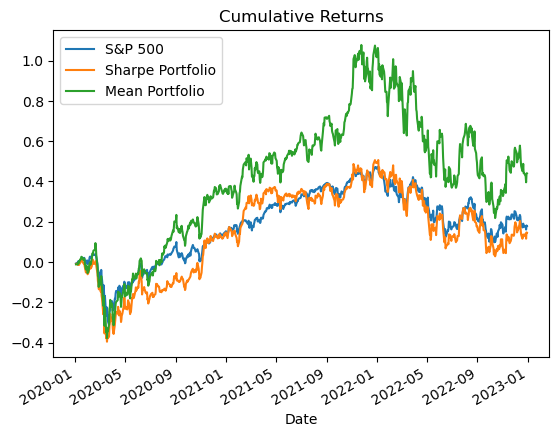

In [80]:
# Lineplot to compare cumulative returns.
c_df4.plot()
plt.title('Cumulative Returns')

### Comparing With Individual Stocks

We will now compare the metrics of all selected stocks in order to see if holding the portfolio would be better than holding the individual stocks. 

In [65]:
# All the stocks selected for both portfolios. There is overlap with LVS, LYV, and CDW.
final_tickers = ['LVS', 'LYV', 'CDW', 'AMD', 'NVDA', 'STE', 'ZBRA']

In [66]:
# Subsetting date for after 2020-01-01 with only selected stocks.
df_test_stocks = df[(df.index >= '2020-01-01') & (df.index <= '2023-01-01')][['LYV', 'LVS', 'CDW', 'STE', 'ZBRA', 'AMD', 'NVDA']]

In [67]:
# Changing values to percentage changes.
df_test_stocks = df_test_stocks.pct_change()

In [82]:
# Stocks mean daily returns.
df_test_stocks.mean()

LYV     0.000549
LVS     0.000069
CDW     0.000601
STE     0.000497
ZBRA    0.000347
AMD     0.000978
NVDA    0.001806
dtype: float64

In [69]:
# Stocks daily standard deviation.
df_test_stocks.std()

LYV     0.034350
LVS     0.033347
CDW     0.023160
STE     0.020045
ZBRA    0.026795
AMD     0.035007
NVDA    0.035262
dtype: float64

In [70]:
# Stocks Sharpe ratio.
df_test_stocks.mean() / df_test_stocks.std()

LYV     0.015993
LVS     0.002059
CDW     0.025945
STE     0.024812
ZBRA    0.012947
AMD     0.027927
NVDA    0.051213
dtype: float64

In [71]:
# Stocks cumulative return.
df_stocks = (df_test_stocks + 1).cumprod() - 1

In [72]:
# Showing last row with latest cumulative return.
df_stocks.tail(1)

,LYV,LVS,CDW,STE,ZBRA,AMD,NVDA
Date,,,,,,,
2022-12-30,-0.029907,-0.3075,0.284394,0.25002,-0.010535,0.319145,1.445017


In [73]:
# Creating a function to create a dataframe with all the calculated metrics for selected stocks.
def stock_connect(tickers):
    """
    Combines mean daily return, standard deviation, Sharpe ratio, and cumulative return
    into one dataframe for a list of tickers.
    """
    df_ = pd.DataFrame()
    for ticker in tickers:
        data = {ticker: [df_test_stocks[ticker].mean(), df_test_stocks[ticker].std(), \
                    (df_test_stocks[ticker].mean() / df_test_stocks[ticker].std()), \
                    ((df_test_stocks + 1).cumprod() - 1)[ticker].tail(1)[0]]}
        df_ = pd.concat([df_, pd.DataFrame(data, index=['Mean Daily Return', 'Standard Deviation',\
                                                        'Sharpe Ratio', 'Cumulative Return'])], axis=1)
    return df_

In [74]:
# Running function and storing the resulting dataframe.
df_stocks_final = stock_connect(final_tickers)

In [75]:
# Combining stocks dataframe with portfolios/index to get one dataframe for easy comparison.
pd.concat([df_compare, df_stocks_final], axis=1)

,S&P 500,Sharpe Portfolio,Mean Portfolio,LVS,LYV,CDW,AMD,NVDA,STE,ZBRA
Mean Daily Return,0.000347,0.000413,0.000800,0.000069,0.000549,0.000601,0.000978,0.001806,0.000497,0.000347
Standard Deviation,0.016041,0.021509,0.025117,0.033347,0.034350,0.023160,0.035007,0.035262,0.020045,0.026795
Sharpe Ratio,0.021625,0.019184,0.031870,0.002059,0.015993,0.025945,0.027927,0.051213,0.024812,0.012947
Cumulative Return,0.181540,0.145785,0.440068,-0.307500,-0.029907,0.284394,0.319145,1.445017,0.250020,-0.010535


From the summary of results, the **Mean Portfolio** that held **LVS, LYV, CDW, AMD, and NVDA** outperformed both the S&P 500 and Sharpe Portfolio. **It had the highest risk-adjusted return based on the Sharpe ratio, while also having the highest cumulative return.** It also performed better than all its constituent stocks held individually except for NVDA. However, NVDA had an exceptional run and holding only NVDA out of all possible stocks would have been extremely lucky. The Mean Portfolio would also have had less volatility as seen from the lower standard deviation compared to NVDA. 

**Therefore, we will select five stocks for the final portfolio based on the highest mean daily returns.**

### Selecting Five Stocks For Final Portfolio

We will use a more recent 5-year period to select our final five stocks, **starting from 2018-08-10 to 2023-08-10.**

In [76]:
# Subset dataframe for 2018-08-01 and later
df_select = df[df.index >= '2018-08-10']

In [77]:
# Change values to percentage changes.
df_select = df_select.pct_change()

In [78]:
# Calculate mean daily returns and display the top five stocks with highest values.
df_select.mean().nlargest(5)

ON      0.002792
FICO    0.002240
CEG     0.002139
NVDA    0.002089
AMD     0.002036
dtype: float64

## Final Results <a name="final"></a>
<hr style="border:1px solid gray">

**Five stocks to hold in an equal-weighted portfolio now (2023-08-10) for a period of 3 years in order to potentially outperform the S&P 500 index on an absolute and risk-adjusted basis are:**

##### 1) ON - ON Semiconductor Corporation
##### 2) FICO - Fair Isaac Corporation
##### 3) CEG - Constellation Energy Corporation
##### 4) NVDA - NVIDIA Corporation
##### 5) AMD - Advanced Micro Devices, Inc.